# View Graph For Indoor Navigation



## Test Environments
### Hypothetical Floor Plan (Basic)
<div>
<img src="envs/hypo_basic.png" width="500"/>
</div>

### Hypothetical Floor Plan
<div>
<img src="envs/hypo_advanced.png" width="500"/>
</div>

### Real World Environment (University Layout)
<div>
<img src="envs/mc5.png" width="500"/>
</div>


### Real World Environment (Regent Place Shopping Mall)
Constructed from - with minor simplification: https://www.regentplace.com.au/floor-plan
<div>
<img src="envs/regent_place.png" width="500"/>
</div>

### Test Environment Constructed From Liu and Zlatanova (2011)
<div>
<img src="envs/sisi.png" width="500"/>
</div>

## References
### Configurational and Route Information
* Werner S, Krieg-Brückner B, Mallot HA, Schweizer K, Freksa C. Spatial cognition: The role of landmark, route, and survey knowledge in human and robot navigation. In Informatik’97 Informatik als Innovationsmotor 1997 (pp. 41-50). Springer, Berlin, Heidelberg.

### Space Decomposition:
* Peponis J. Geometries of architectural description. In Space Syntax. First International Symposium Proceedings 1997 (Vol. 2, p. 34).
* Amoozandeh K, Winter S, Tomko M. Space decomposition based on visible objects in an indoor environment. Environment and Planning B: Urban Analytics and City Science. 2021 Aug 11:23998083211037347.

### Route/Navigation Graphs
* Yang L, Worboys M. Generation of navigation graphs for indoor space. International Journal of Geographical Information Science. 2015 Oct 3;29(10):1737-56.
* Liu L, Zlatanova S. A "door-to-door" path-finding approach for indoor navigation. Proceedings Gi4DM 2011: GeoInformation for Disaster Management, Antalya, Turkey, 3-8 May 2011. 2011.
* Mortari F, Zlatanova S, Liu L, Clementini E. Improved geometric network model (IGNM): A novel approach for deriving connectivity graphs for indoor navigation. ISPRS Annals of Photogrammetry, Remote Sensing & Spatial Information Sciences. 2014 Apr 23;2(4).
* Zhou Z, Weibel R, Richter KF, Huang H. HiVG: A hierarchical indoor visibility-based graph for navigation guidance in multi-storey buildings. Computers, Environment and Urban Systems. 2022 Apr 1;93:101751.
* Pang Y, Zhou L, Lin B, Lv G, Zhang C. Generation of navigation networks for corridor spaces based on indoor visibility map. International Journal of Geographical Information Science. 2020 Jan 2;34(1):177-201.

### Place Graphs:
* Vasardani, M., Timpf, S., Winter, S. and Tomko, M., 2013. From descriptions to depictions: A conceptual framework. In Spatial Information Theory: 11th International Conference, COSIT 2013, Scarborough, UK, September 2-6, 2013. Proceedings 11 (pp. 299-319). Springer International Publishing.
* Chen, H., Vasardani, M., Winter, S. and Tomko, M., 2018. A graph database model for knowledge extracted from place descriptions. ISPRS International Journal of Geo-Information, 7(6), p.221.
* Becker T, Nagel C, Kolbe TH. A multilayered space-event model for navigation in indoor spaces. In3D geo-information sciences 2009 (pp. 61-77). Springer, Berlin, Heidelberg.

## Setup

### Loading classes

In [1]:
# Parameters
from Parameters import Parameters

# Utitlies for mathematical calculation, isovist and visualization
from Isovist import Isovist
from Plotter import Plotter
from Utility import Utility

# Container -> Environment -> View Graph
from Container import Container
from Environment import IndoorEnvironment
from ViewGraph import ViewGraph

from pyvis.network import Network

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

### Variables and parameters

In [2]:
Parameters.set_env("real")  # this can be set to "basic" environment, "hypo" environment as well
Parameters.print_info()

--------------------------------------
Real-world environment is active

Static Variables: 
	epsilon: 0.01
	precision: 2
	alpha: 40
	fov: 160
	min_area: 0.005
	max_distance: 1000000
	door_weight: 50
	turn_weight: 0.05
--------------------------------------


### Reading Datasets

In [3]:
def read_env():
    # Basic environment
    if Parameters.basic:
        address = 'envs/basic/'
        pfiles = ['t_bound.geojson']
        hfiles = [None]
        dfiles = ['t_doors.geojson']
        dpfiles = [None]
        lfiles = ['t_landmarks.geojson']
        # create an indoor environment
        ie = IndoorEnvironment(address, pfiles, hfiles, dfiles, dpfiles, lfiles)

    # Hypo environment
    elif Parameters.hypo:
        address = 'envs/hypo/'
        pfiles = ['hypo_env.geojson']
        hfiles = ['hypo_holes.geojson']
        dfiles = ['hypo_doors.geojson']
        dpfiles = ['hypo_dpoints.geojson']
        lfiles = ['hypo_landmarks.geojson']
        # create an indoor environment
        ie = IndoorEnvironment(address, pfiles, hfiles, dfiles, dpfiles, lfiles)

    # MC5 real world environment
    else:
        if Parameters.mc:
            address = 'envs/mc-floor-5/'
        else:
            address = 'envs/RegentPlace'
        pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
            address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
        # create an indoor environment
        ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)
    
    return ie

## University Layout

In [4]:
ie = read_env()

environment files -- count is valid
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)


### Decomposing regions into isovists, and create view graph
Here, the following tasks are performed:
   * calculate isovists
   * decompose containers to regions
   * calculate visiblity signature for each region
   * create adjacency matrix
   * find initial views
   * decompose views
   * construct view graph
   * calculate spatial relationships
   * augment the actions in view graphs (to nodes and edges)

In [5]:
# create view graph
vgs, isovist_objects = ie.construct_view_graph()


*******************************************
Analyzing: Emergency Stairs
Container environment is valid: True
region initial : 1
regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 12
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Women Toilet
Container environment is valid: True
region initial : 3
regions : 4 -- 3
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 49
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*********************************

In [6]:
ie.containers_names

['Emergency Stairs',
 'Women Toilet',
 'Disabled Toilet',
 'Men Toilet',
 'Corridor',
 'Active Hub',
 'Stairs to Lower Floors',
 'Ngi-a Djerring Gat-ith',
 'UX Lab']

## Shortest Path and Route Instruction
Here, we first generate a shortest path from a region to another. Then we use the augmented actions and relationships in view graph to generate route instructions from its results.

In [7]:
# set parameters to Parameters class
start_container = 'Women Toilet'
start_region = 3
end_container = 'Active Hub'
end_region = 3

enter: Corridor
enter: Active Hub


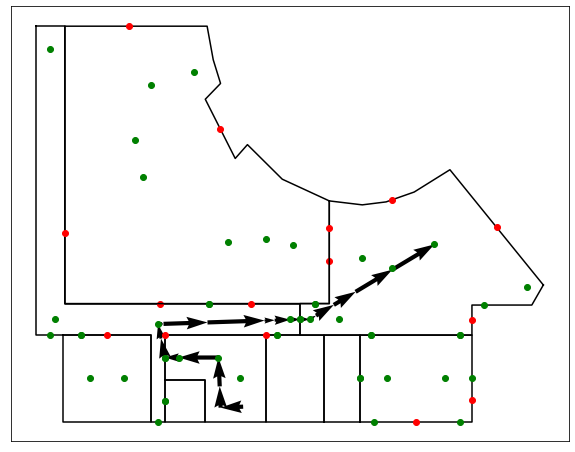

<Figure size 720x576 with 0 Axes>

In [8]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

In [9]:
# generate route instructions
def generate_route_descriptions(vp):
    container = ''
    container_vids = {}
    finals = {}
    for v in vp[1:-1]:
        info = v.split('-V')
        if container != info[0]:
            container = info[0]
            container_vids[container] = []
        container_vids[container].append(int(info[1]))
    for container, vids in container_vids.items():
        cidx = ie.containers_names.index(container)
        vg = vgs[cidx]
        rds = vg.generate_route_description(vids)
        finals[container] = rds
    return finals

def print_route_descriptions(rd_dictionary):
    containers = list(rd_dictionary.keys())
    for container in containers:
        rd = rd_dictionary[container]
        if containers.index(container) < len(containers) - 1:
            rd[len(rd)-1] = rd[len(rd)-1].replace('until you reach the destination', 'to enter {}'.format(containers[containers.index(container)+1]))
        for r in rd:
            print(r)
# vg.generate_route_description(vp)
print_route_descriptions(generate_route_descriptions(vp))

Head towards decision point 1 and turn left
Pass decision point 1 and move forward to enter Corridor
Head towards the door to women toilet
Pass the door to women toilet and veer right
Pass the door to male toilet and move forward to enter Active Hub
Head towards the door to corridor
Pass the landmark 0 and move forward until you reach the destination


## Derive Door-to-Door Visibility Graph


### Generate door-to-door visibility graph (for doors and decision points)

In [10]:
# selecting a space
cidx = ie.containers_names.index('Active Hub')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

generate door-to-door graph, only_doors False from view graph
Press Enter: Door to door visibility (doors+gateways)


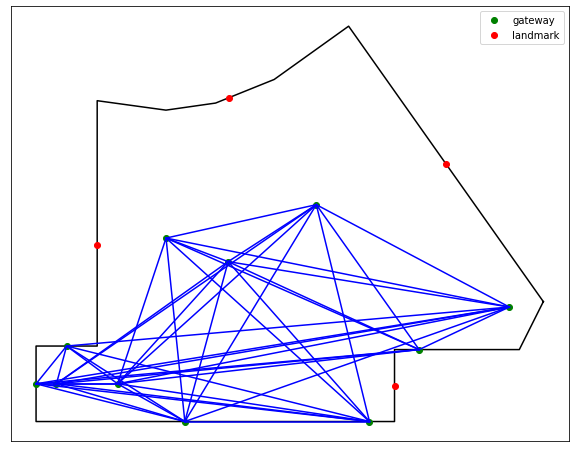

<Figure size 720x576 with 0 Axes>

In [11]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

print('Press Enter: Door to door visibility (doors+gateways)')
plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()
plotter.write_graph('d-t-d-all.html', dtd_graph, is_directed=False)

## Generate door-to-door visibility graph (only for doors)

generate door-to-door graph, only_doors True from view graph


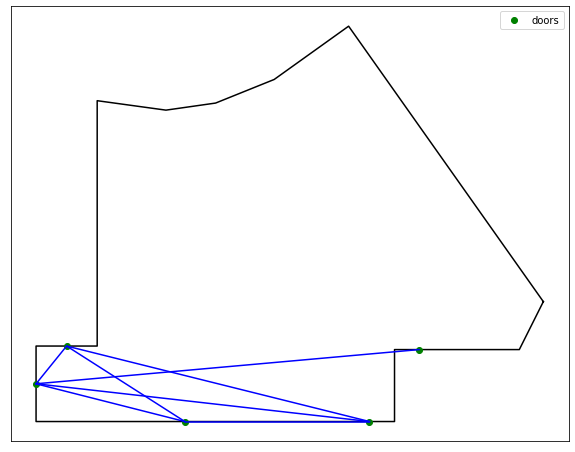

<Figure size 720x576 with 0 Axes>

In [12]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()
plotter.write_graph('d-t-d-doors.html', dtd_graph2, is_directed=False)

In [13]:
nt2 = Network(width='1000px', height='600px', directed=False, notebook=True)
nt2.from_nx(dtd_graph2, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('d-t-d-doors.html')

## Derive navigation graph


<b>Reference</b>
* Yang L, Worboys M. Generation of navigation graphs for indoor space. International Journal of Geographical Information Science. 2015 Oct 3;29(10):1737-56.
* Pang Y, Zhou L, Lin B, Lv G, Zhang C. Generation of navigation networks for corridor spaces based on indoor visibility map. International Journal of Geographical Information Science. 2020 Jan 2;34(1):177-201.

derive navigation graph using spanning tree from viewgraph


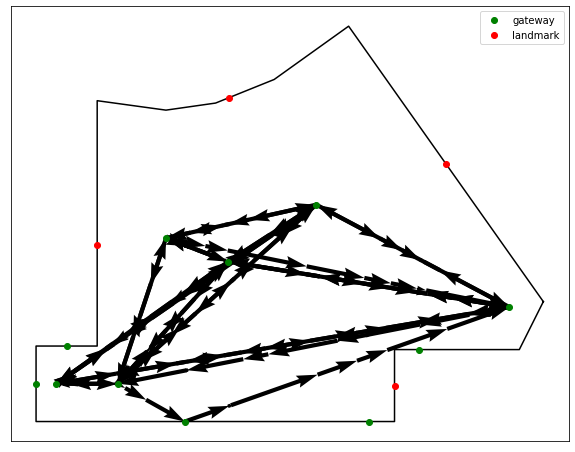

In [14]:
# derive all shortest path visibility graph and spanning tree
vps, pvs, st_vps, st_pvs, nvgraph = \
    vg.generate_navigation_graph(isovist_object, indirect_access=False)

plotter = Plotter()
plotter.add_isovist(isovist_object)

for pv in pvs:
    plotter.add_views(pv)
plotter.show()

<Figure size 720x576 with 0 Axes>

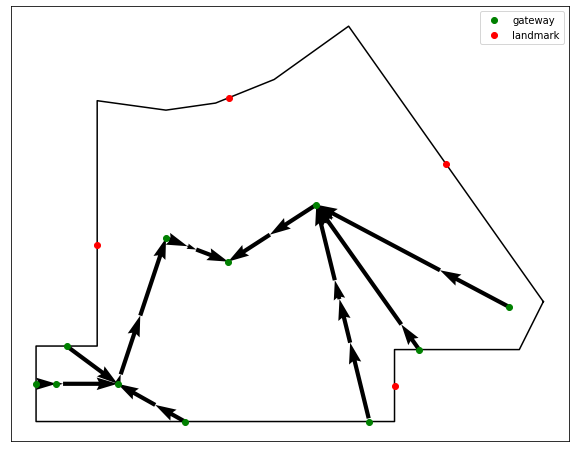

In [15]:
plotter.refresh()
for pv in st_pvs:
    plotter.add_views(pv)
plotter.show()

<Figure size 720x576 with 0 Axes>

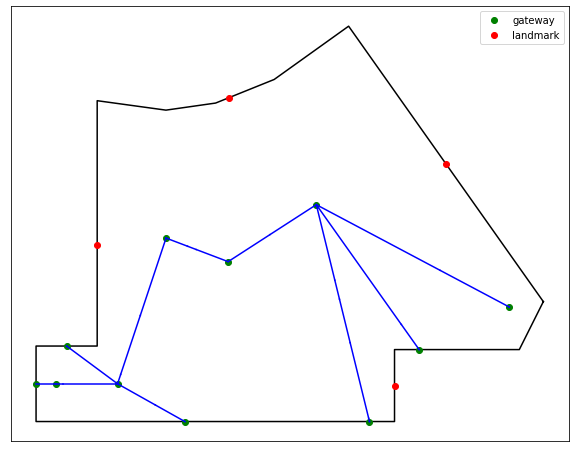

In [16]:
plotter.refresh()
for pv in st_pvs:
    plotter.add_points_lines(pv, is_vis=False)
plotter.show()

In [17]:
# generate navigation 'graph' for gateways + doors
nt2 = Network(width='1000px', height='600px', directed=False, notebook=True)
nt2.from_nx(nvgraph, show_edge_weights=False)
nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                    'spring_strength': 0.05, 'damping': 0.09})

nt2.show('nvgraph.html')

## Derive place graph from view graph

Nodes:
* place
* reference
* n-plet
* spatial relationship


Edges:
* locatum
* relatum
* map
* referred by
* has reference direction

<b>Reference</b>: Chen H, Vasardani M, Winter S, Tomko M. A graph database model for knowledge extracted from place descriptions. ISPRS International Journal of Geo-Information. 2018 Jun;7(6):221.


In [18]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


In [19]:
print('Place graph generation; visualize for all and only for landmark 2')
plotter.write_graph('placegraph.html', place_graph)

Place graph generation; visualize for all and only for landmark 2


In [20]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

In [21]:
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


### Single Nplet
Select a single n-plet from different spatial relationships and visualize the graph and spatial configuration

1. between
2. near
3. left/right

In [22]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

def nplet_extraction(nplet_id):
    ## nplet_id = 'n830'
    place_graph[nplet_id]  # left
    # place_graph['n100'] # between

    # nodes = ['n830', 'left', 'place12', 'gateway 12', 'landmark 20', 'gateway 1']
    nodes = [nplet_id]
    nodes.extend(list(dict(place_graph[nplet_id]).keys()))

    additional = []
    for node in nodes:
        if node.startswith('place'):
            additional.extend(list(dict(place_graph[node]).keys()))
    nodes.extend(additional)

    for v in list(place_graph.edges):
        if v[1] == nplet_id:
            nodes.append(v[0])
            if v[0].startswith('place'):
                nodes.extend(list(dict(place_graph[v[0]]).keys()))

    nplets = place_graph.subgraph(nodes)
    nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
    nt2.from_nx(nplets, show_edge_weights=False)
    nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                        'spring_strength': 0.05, 'damping': 0.09})
    return nt2, nodes

spatial_expression = 'the door to women toilet between the landmark 2 and the door to disabled toilet'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')


## Regent Place - Shopping Mall

Testing the view graph capabilities in computing shortest path, generating route descriptions, navigation graphs and place graphs in another test environment: Regenet Place Shopping Mall (https://www.regentplace.com.au/floor-plan)

### Reading the Floorplan Files

In [23]:
# reading the new floorplan dataset
Parameters.set_env(env="real", mc=False)
address = 'envs/RegentPlace/'
pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
    address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
# create an indoor environment
ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)

environment files -- count is valid
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (bou

### Creating View Graph

In [24]:
# creating view graph
vgs, isovist_objects = ie.construct_view_graph()


*******************************************
Analyzing: Ice Kirin Bar
Container environment is valid: True
region initial : 1
regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 20
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: Shop
Container environment is valid: True
region initial : 3
regions : 2 -- 3
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 14
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************


### Shortest Path Computation

In [25]:
ie.containers_names

['Ice Kirin Bar',
 'Shop',
 'Fireside By Yunn',
 'Yakitori Yokocho',
 'Loading Dock',
 'Fujimi Bakehouse',
 'Daiso',
 'The Parks Sydney',
 'Mido Mart',
 'Toilet',
 'Yakinku Yokocho',
 'Dioa by Devon',
 'Arctic White',
 'Edomae Sushi',
 'FraserSuites',
 'Corridor']

In [26]:
# set parameters to Parameters class
start_container = 'Ice Kirin Bar'
start_region = 0
end_container = 'Daiso'
end_region = 1

enter: Corridor
enter: Daiso


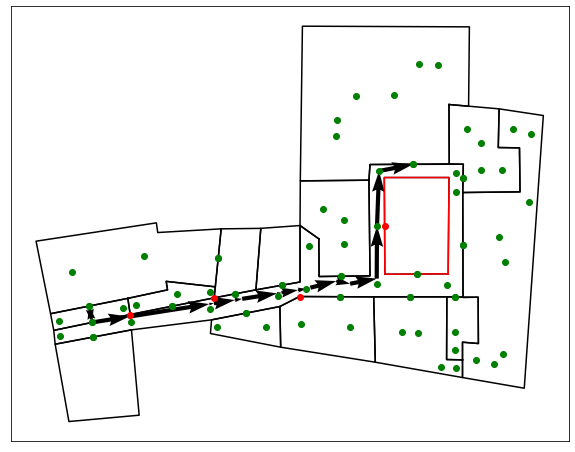

<Figure size 720x576 with 0 Axes>

In [27]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

### Generating Route Description

In [28]:
# generate route instructions
def generate_route_descriptions(vp):
    container = ''
    container_vids = {}
    finals = {}
    for v in vp[1:-1]:
        info = v.split('-V')
        if container != info[0]:
            container = info[0]
            container_vids[container] = []
        container_vids[container].append(int(info[1]))
    for container, vids in container_vids.items():
        cidx = ie.containers_names.index(container)
        vg = vgs[cidx]
        rds = vg.generate_route_description(vids)
        finals[container] = rds
    return finals

def print_route_descriptions(rd_dictionary):
    containers = list(rd_dictionary.keys())
    for container in containers:
        rd = rd_dictionary[container]
        if containers.index(container) < len(containers) - 1:
            rd[len(rd)-1] = rd[len(rd)-1].replace('until you reach the destination', 'to enter {}'.format(containers[containers.index(container)+1]))
        for r in rd:
            print(r)
# vg.generate_route_description(vp)
print_route_descriptions(generate_route_descriptions(vp))

Head towards the door to Corridor and move forward to enter Corridor
Head towards the door to Ice Kirin Bar
Pass decision point 11 and turn left
Follow decision point 7 on the front and turn right and move forward until you reach the destination


### Creating Navigation Graphs - Door-to-Door

In [29]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

generate door-to-door graph, only_doors False from view graph


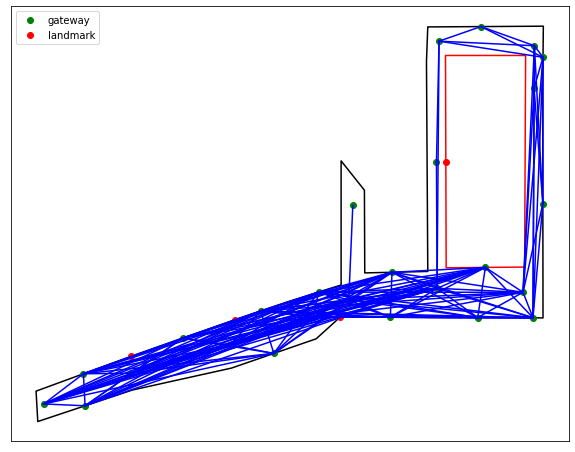

<Figure size 720x576 with 0 Axes>

In [30]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()

generate door-to-door graph, only_doors True from view graph


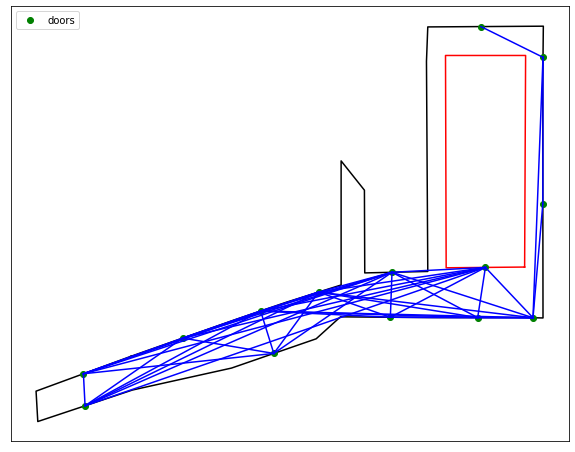

<Figure size 720x576 with 0 Axes>

In [31]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()

### Creating Place Graph

In [32]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


In [33]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

def nplet_extraction(nplet_id):
    ## nplet_id = 'n830'
    place_graph[nplet_id]  # left
    # place_graph['n100'] # between

    # nodes = ['n830', 'left', 'place12', 'gateway 12', 'landmark 20', 'gateway 1']
    nodes = [nplet_id]
    nodes.extend(list(dict(place_graph[nplet_id]).keys()))

    additional = []
    for node in nodes:
        if node.startswith('place'):
            additional.extend(list(dict(place_graph[node]).keys()))
    nodes.extend(additional)

    for v in list(place_graph.edges):
        if v[1] == nplet_id:
            nodes.append(v[0])
            if v[0].startswith('place'):
                nodes.extend(list(dict(place_graph[v[0]]).keys()))

    nplets = place_graph.subgraph(nodes)
    nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
    nt2.from_nx(nplets, show_edge_weights=False)
    nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                        'spring_strength': 0.05, 'damping': 0.09})
    return nt2, nodes

spatial_expression = 'the landmark 1 between the door to Fireside By Yunn and the door to Fujimi Bakehouse'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')

## Hypothetical Floorplan (with holes)

In [34]:
Parameters.set_env(env="hypo", mc=False)
print(Parameters.min_area)

5e-07


In [35]:
ie = read_env()

environment files -- count is valid
reading GeoJSON files (boundary, holes, doors and decision points)


### Creating View Graph

In [36]:
# creating view graph
vgs, isovist_objects = ie.construct_view_graph()


*******************************************
Analyzing: Container
Container environment is valid: True
region initial : 272
regions : 115 -- 272
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 1458
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)


## Shortest Path and Route Instruction

In [37]:
# set parameters to Parameters class
start_container = 'Container'
start_region = 0
end_container = 'Container'
end_region = 60

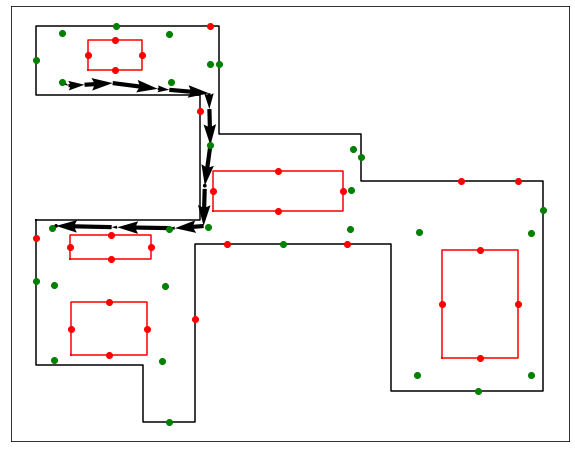

<Figure size 720x576 with 0 Axes>

In [38]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

### Generating Route Descriptions

In [39]:
# generate route instructions
def generate_route_descriptions(vp):
    container = ''
    container_vids = {}
    finals = {}
    for v in vp[1:-1]:
        info = v.split('-V')
        if container != info[0]:
            container = info[0]
            container_vids[container] = []
        container_vids[container].append(int(info[1]))
    for container, vids in container_vids.items():
        cidx = ie.containers_names.index(container)
        vg = vgs[cidx]
        rds = vg.generate_route_description(vids)
        finals[container] = rds
    return finals

def print_route_descriptions(rd_dictionary):
    containers = list(rd_dictionary.keys())
    for container in containers:
        rd = rd_dictionary[container]
        if containers.index(container) < len(containers) - 1:
            rd[len(rd)-1] = rd[len(rd)-1].replace('until you reach the destination', 'to enter {}'.format(containers[containers.index(container)+1]))
        for r in rd:
            print(r)
# vg.generate_route_description(vp)
print_route_descriptions(generate_route_descriptions(vp))

Head towards the landmark 21
Pass the landmark 21 and turn right
Pass the landmark 18 and turn right
Pass decision point 15 and move forward until you reach the destination


### Creating Navigation Graphs

In [40]:
# selecting a space
cidx = 0
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

generate door-to-door graph, only_doors False from view graph


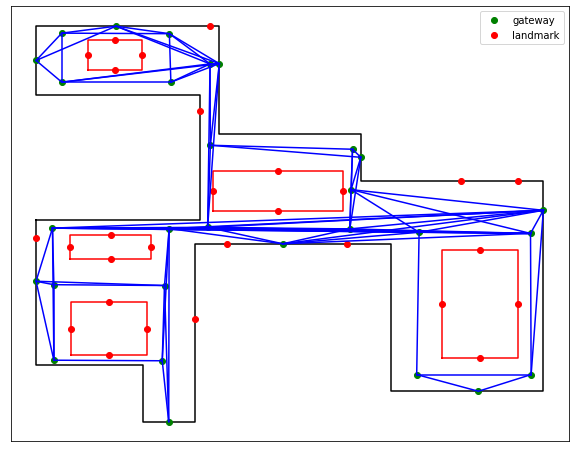

<Figure size 720x576 with 0 Axes>

In [41]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()

generate door-to-door graph, only_doors True from view graph


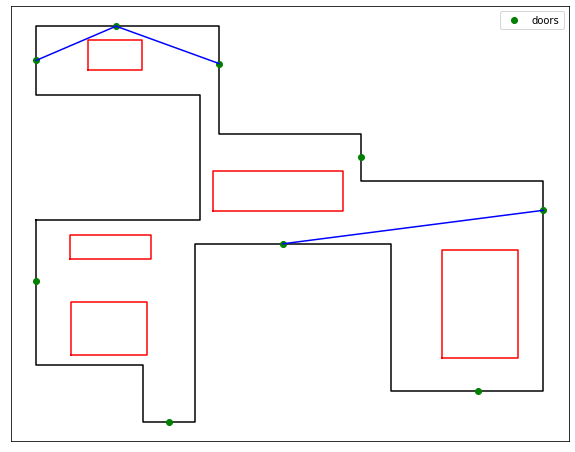

<Figure size 720x576 with 0 Axes>

In [42]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()

### Creating Place Graphs

In [43]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


In [44]:
# selecting a space
cidx = 0
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

def nplet_extraction(nplet_id):
    ## nplet_id = 'n830'
    place_graph[nplet_id]  # left
    # place_graph['n100'] # between

    # nodes = ['n830', 'left', 'place12', 'gateway 12', 'landmark 20', 'gateway 1']
    nodes = [nplet_id]
    nodes.extend(list(dict(place_graph[nplet_id]).keys()))

    additional = []
    for node in nodes:
        if node.startswith('place'):
            additional.extend(list(dict(place_graph[node]).keys()))
    nodes.extend(additional)

    for v in list(place_graph.edges):
        if v[1] == nplet_id:
            nodes.append(v[0])
            if v[0].startswith('place'):
                nodes.extend(list(dict(place_graph[v[0]]).keys()))

    nplets = place_graph.subgraph(nodes)
    nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
    nt2.from_nx(nplets, show_edge_weights=False)
    nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                        'spring_strength': 0.05, 'damping': 0.09})
    return nt2, nodes

spatial_expression = 'door 4 between the landmark 8 and the landmark 26'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')

## Hypothetical Environment

### constructed from Liu and Zlatanova (2011)

In [45]:
# reading the new floorplan dataset
Parameters.set_env(env="real", mc=True)
address = 'envs/paper/'
pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
    address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
# create an indoor environment
ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)

environment files -- count is valid
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)
reading GeoJSON files (boundary, holes, doors and decision points)


In [46]:
ie.containers_names

['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11']

## View Graph Construction

In [47]:
# creating view graph
vgs, isovist_objects = ie.construct_view_graph()


*******************************************
Analyzing: c1
Container environment is valid: True
region initial : 10
regions : 10 -- 10
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 116
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing: c2
Container environment is valid: True
region initial : 1
regions : 1 -- 1
calculating the visibility signatures...
calculating adjacency matrix for regions
finding regions that contains doors/gateways and decision points
decompose views
len: 20
constructing view graph for regions
calculating all spatial relationships visible in each view
Adding actions to views (nodes)
Adding actions to view relations (edges)

*******************************************
Analyzing

generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph


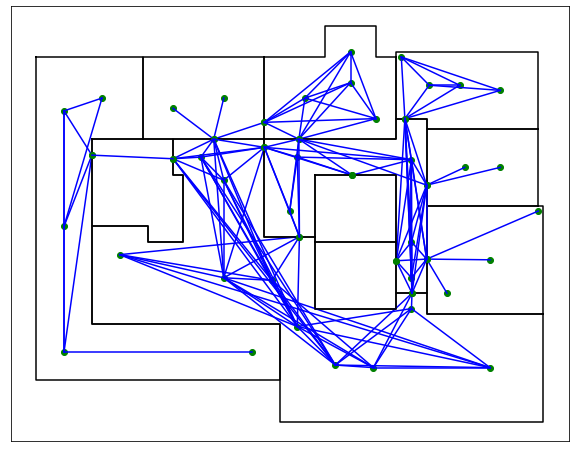

<Figure size 720x576 with 0 Axes>

In [48]:
# derive door-to-door visibility graph (doors+gateways)
plotter = Plotter()
for idx,vg in enumerate(vgs):
    isovist_object = isovist_objects[idx]
    connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=False)
    plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
    plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
    plotter.add_points(isovist_object.door_points, 'gateways')
    plotter.add_points_lines(connected2)
plotter.show(False)
plotter.close()

### Computing Shortest Path Using Door-to-Door Graph

In [49]:
gids = Utility.global_gateway_ids(ie)
gids
gids_rev = {}
for cname, vals in gids.items():
    for did, gid in vals.items():
        if gid not in gids_rev:
            gids_rev[gid] = []
        gids_rev[gid].append({'container': cname, 'did': did})

In [50]:
door_to_door_graph = Utility.generate_door_to_door_graph(ie)

generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph
generate door-to-door graph, only_doors False from view graph


In [51]:
container = 'c11'
door_id = 1
container2 = 'c6'
door_id2 = 0

import networkx as nx
path = nx.shortest_path(door_to_door_graph,gids[container][door_id], gids[container2][door_id2])

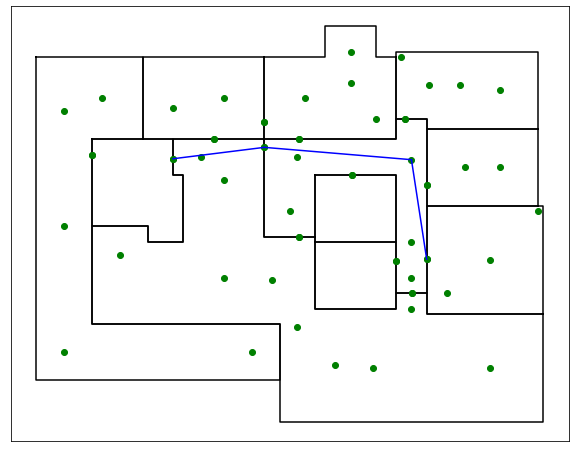

<Figure size 720x576 with 0 Axes>

In [52]:
plotter = Plotter()
for idx,vg in enumerate(vgs):
    isovist_object = isovist_objects[idx]
    plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
    plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
    plotter.add_points(isovist_object.door_points, 'gateways')
for idx, gid in enumerate(path[:-1]):
    gid2 = path[idx+1]
    c1 = ie.isovist_objects[ie.containers_names.index(gids_rev[gid][0]['container'])].door_points[gids_rev[gid][0]['did']]
    c2 = ie.isovist_objects[ie.containers_names.index(gids_rev[gid2][0]['container'])].door_points[gids_rev[gid2][0]['did']]
    plotter.add_points_lines([[c1, c2]])
plotter.show(False)
plotter.close()